In [4]:
import gym
#env = gym.make("FrozenLake-v1")
env = gym.make('CartPole-v1')

In [1]:
import torch
import torch.nn.functional as F
from torch.optim import Adam

In [3]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
class LinearClassifier(torch.nn.Module):
    def __init__(self,lr,n_classes,input_dims):
        super(LinearClassifier).__init__()
        
        self.fc1=torch.nn.Linear(input_dims,128)
        self.fc2=torch.nn.Linear(128,256)
        self.fc3=torch.nn.Linear(256,n_classes)
        self.optimizer=Adam(self.parameters(),lr=lr)
        self.criterion=torch.nn.CrossEntropyLoss()
    
    def forward(self,x):
        out=F.sigmoid(self.fc1(x))
        out=F.sigmoid(self.fc2(out))
        out=self.fc3(out)
        return out
    
    def learn(self,data,labels):
        self.optimizer.zero_grad()
        data=torch.tensor(data).to(device)
        labels=torch.tensor(labels).to(device)
        predictions=self(data)
        cost=self.criterion(predictions,labels)
        cost.backward()
        self.optimizer.step()

## Define Agent and Q matrix estimator (Network)

In [52]:
class NetworkEstimator(torch.nn.Module):
    def __init__(self,lr,n_actions,input_dims):
        super(NetworkEstimator,self).__init__()
        
        self.fc1=torch.nn.Linear(*input_dims,256)
        self.fc2=torch.nn.Linear(256,n_actions)
        self.criterion=torch.nn.MSELoss()
        self.optimizer=Adam(self.parameters(),lr=lr)
    
    def forward(self,state):
        out=F.relu(self.fc1(state))
        actions=self.fc2(out)
        return actions
    
class Agent():
    def __init__(self,input_dims,n_actions,lr,gamma=0.99,epsilon=1.0,eps_dec=1e-5,eps_min=0.01):
        self.lr=lr
        self.input_dims=input_dims
        self.n_actions=n_actions
        self.gamma=gamma
        self.epsilon=epsilon
        self.eps_dec=eps_dec
        self.eps_min=eps_min
        self.action_space=[i for i in range(self.n_actions)]
        
        self.Q=NetworkEstimator(self.lr,self.n_actions,self.input_dims).to(DEVICE)
        
    def choose_action(self,observation):
        if np.random.random() > self.epsilon:
            state=torch.tensor(observation,dtype=torch.float).to(DEVICE)
            actions=self.Q.forward(state)
            action=torch.argmax(actions).item()
        else:
            action=np.random.choice(self.action_space)
        return action
    
    
        
    def decrease_epsilon(self):
        self.epsilon=self.epsilon-self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        
        
    def learn(self,state,action,reward,new_state):
        self.Q.optimizer.zero_grad()
        states=torch.tensor(state,dtype=torch.float).to(DEVICE)
        actions=torch.tensor(action).to(DEVICE)
        rewards=torch.tensor(reward).to(DEVICE)
        new_states=torch.tensor(new_state,dtype=torch.float).to(DEVICE)
        
        q_pred=self.Q(states)[actions]
        q_next=self.Q(new_states).max()
        q_target=reward+self.gamma*q_next
        loss= self.Q.criterion(q_target,q_pred)
        loss.backward()
        self.Q.optimizer.step()
        self.decrease_epsilon()

### Play game and learn

In [62]:
import numpy as np
def play_pole(env_game,n_games,n_games_eval=100):
    scores=[]
    avg_scores=[]
    eps_history=[]
    
    agent=Agent(env_game.observation_space.shape,env_game.action_space.n,0.001)
    for game in range(n_games):
        state=env_game.reset()
        game_over=False
        score=0
        while not game_over:
            #action=agent.choose_action(state)
            action=agent.choose_action(state)
            new_state, reward, game_over, info = env_game.step(action)
            agent.learn(state,action,reward,new_state)
            score+=reward
            state=new_state
            
        scores.append(score)
        
        if game%n_games_eval==0:
            avg_score=np.mean(scores[-n_games_eval:])
            avg_scores.append(avg_score)
            eps_history.append(agent.epsilon)
            print(f"Episode {game} | Score: {scores[-1]:.2f} Avg Score {avg_score:.2f} | Epsilon {agent.epsilon:.3f}")
    
    return avg_scores,eps_history



In [63]:
N_GAMES=100000
scores_game,epsilons=play_pole(env,N_GAMES,1000)

Episode 0 | Score: 19.00 Avg Score 19.00 | Epsilon 1.000
Episode 1000 | Score: 46.00 Avg Score 24.37 | Epsilon 0.756
Episode 2000 | Score: 44.00 Avg Score 32.71 | Epsilon 0.429
Episode 3000 | Score: 9.00 Avg Score 33.71 | Epsilon 0.092
Episode 4000 | Score: 10.00 Avg Score 13.96 | Epsilon 0.010
Episode 5000 | Score: 9.00 Avg Score 11.54 | Epsilon 0.010
Episode 6000 | Score: 10.00 Avg Score 11.31 | Epsilon 0.010
Episode 7000 | Score: 9.00 Avg Score 10.61 | Epsilon 0.010
Episode 8000 | Score: 10.00 Avg Score 10.96 | Epsilon 0.010
Episode 9000 | Score: 10.00 Avg Score 10.81 | Epsilon 0.010
Episode 10000 | Score: 9.00 Avg Score 12.73 | Epsilon 0.010
Episode 11000 | Score: 10.00 Avg Score 10.73 | Epsilon 0.010
Episode 12000 | Score: 9.00 Avg Score 11.19 | Epsilon 0.010
Episode 13000 | Score: 10.00 Avg Score 10.96 | Epsilon 0.010
Episode 14000 | Score: 8.00 Avg Score 11.02 | Epsilon 0.010
Episode 15000 | Score: 9.00 Avg Score 11.13 | Epsilon 0.010
Episode 16000 | Score: 10.00 Avg Score 10.93

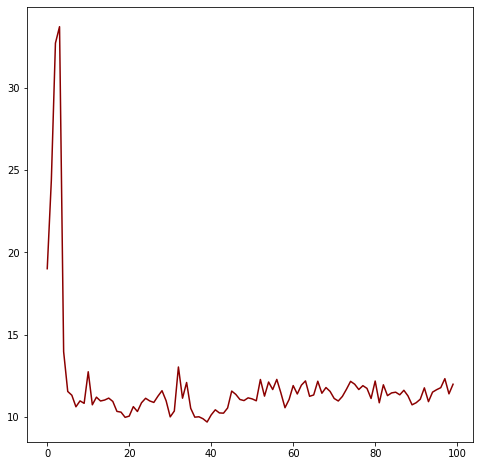

In [64]:
## See results

import seaborn as sns
import matplotlib.pyplot as plt


f,ax=plt.subplots(figsize=(8,8))
ax=sns.lineplot(x=np.arange(len(scores_game)),y=scores_game,color="darkred")

## Using last 3 states for learning


In [326]:
#lets similate n-games and build a dataset
N_GAMES=10000
N_STEPS=4
scores=[]
global_actions=[]
global_observations=[]
for game in range(N_GAMES):
    state=env.reset()
    observations=[]
    counter_steps=0
    game_over=False
    game_over=False
    score=0
    observations=[]
    actions=[]
    while not game_over:
        #action=agent.choose_action(state)
        action=env.action_space.sample()
        new_state, reward, game_over, info = env.step(action)
        score+=reward
        state=new_state
        counter_steps+=1
        new_state[0]*=(1/4.8)   ## standardize position according to  https://www.gymlibrary.dev/environments/classic_control/cart_pole/?highlight=cartpole
        new_state[2]*=(1/0.418)
        observations.append(new_state)
        actions.append(action)
        if counter_steps==N_STEPS and not game_over:
            scores.append(score)
            global_actions.append(actions)
            global_observations.append(observations)
            observations=[]
            actions=[]
            counter_steps=0


In [260]:
len(global_observations)

494200

In [327]:
global_observations=np.stack(global_observations)
global_actions=np.stack(global_actions)

In [328]:
#X,Y=global_observations[:,:-1,:],torch.nn.functional.one_hot(torch.tensor(global_actions[:,-1]), num_classes=2)
X,Y=global_actions[:,:-1],torch.nn.functional.one_hot(torch.tensor(global_actions[:,-1]), num_classes=2)
#X,Y=global_observations[:,:-1,:],torch.tensor(global_actions[:,-1])

## Define Training data
Note: just using it for testing purposes, so not creating a validation set for now

In [330]:
from torch.utils.data import DataLoader,TensorDataset

BATCH_SIZE=128
train_data=TensorDataset(torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float))
train_dl=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

<ipython-input-330-fd1b6aa56685>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data=TensorDataset(torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float))


In [331]:
class NetworkEstimator(torch.nn.Module):
    def __init__(self,n_actions,input_dim=12):
        super(NetworkEstimator,self).__init__()
        self.input_shape=input_dim
        self.fc1=torch.nn.Linear(input_dim,256) #flatten 3 observation with 4 observations each = 3*4=12
        self.fc2=torch.nn.Linear(256,128)
        self.dropout=torch.nn.Dropout(0.3)
        self.fc3=torch.nn.Linear(128,n_actions)
    
    def forward(self,states):
        
        out=F.relu(self.fc1(states.view((-1,self.input_shape))))
        out=F.relu(self.fc2(out))
        out=self.dropout(out)
        out=self.fc3(out)
        return out
model=NetworkEstimator(2,3)

In [332]:
a=next(iter(train_dl))

In [419]:
#define optimizer and loss

criterion=torch.nn.BCEWithLogitsLoss()
#criterion=torch.nn.MSELoss()
optimizer=Adam(model.parameters(),lr=1e-04)
model.to(DEVICE)

NetworkEstimator(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [420]:
##training loop
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

N_EPOCHS=1000
torch.cuda.empty_cache()
model.train()
for epoch in tqdm(range(N_EPOCHS),desc="Training..."):
    actions_pred=[]
    actions_true=[]
    losses=[]
    epoch_loss=0
    for step,(states_batch,actions) in enumerate(train_dl,1):
        model.zero_grad()
        scores=model(states_batch.to(DEVICE))
        loss=criterion(scores,actions.to(DEVICE))
        epoch_loss+=loss.item()
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        actions_true.extend(torch.argmax(actions,1).detach().cpu().numpy().tolist())
        predictions=torch.argmax(scores,1).detach().cpu().numpy().tolist()
        actions_pred.extend(predictions)
        
    ## on epoch end
    losses.append(epoch_loss/X.shape[0])
    if epoch%10==0:
        precision,recall,f1,_=precision_recall_fscore_support(actions_pred,actions_true,average='binary')
        print(f"Epoch {epoch}| Train Loss {epoch_loss:.3f} | Precision {precision:.3f} | Recall {recall:.3f} | F1-score {f1:.3f}")
model.eval()

Training...:   0%|          | 1/1000 [00:00<16:01,  1.04it/s]

Epoch 0| Train Loss 266.834 | Precision 0.581 | Recall 0.507 | F1-score 0.542


Training...:   1%|          | 11/1000 [00:09<14:14,  1.16it/s]

Epoch 10| Train Loss 266.832 | Precision 0.590 | Recall 0.508 | F1-score 0.546


Training...:   2%|▏         | 21/1000 [00:19<16:05,  1.01it/s]

Epoch 20| Train Loss 266.840 | Precision 0.581 | Recall 0.507 | F1-score 0.542


Training...:   3%|▎         | 31/1000 [00:28<14:47,  1.09it/s]

Epoch 30| Train Loss 266.836 | Precision 0.602 | Recall 0.505 | F1-score 0.549


Training...:   4%|▍         | 41/1000 [00:36<14:40,  1.09it/s]

Epoch 40| Train Loss 266.823 | Precision 0.560 | Recall 0.509 | F1-score 0.533


Training...:   5%|▌         | 51/1000 [00:45<14:09,  1.12it/s]

Epoch 50| Train Loss 266.832 | Precision 0.602 | Recall 0.505 | F1-score 0.549


Training...:   6%|▌         | 61/1000 [00:54<14:39,  1.07it/s]

Epoch 60| Train Loss 266.830 | Precision 0.567 | Recall 0.509 | F1-score 0.537


Training...:   7%|▋         | 71/1000 [01:03<13:55,  1.11it/s]

Epoch 70| Train Loss 266.817 | Precision 0.571 | Recall 0.509 | F1-score 0.538


Training...:   8%|▊         | 81/1000 [01:12<13:50,  1.11it/s]

Epoch 80| Train Loss 266.830 | Precision 0.533 | Recall 0.510 | F1-score 0.521


Training...:   9%|▉         | 91/1000 [01:21<13:58,  1.08it/s]

Epoch 90| Train Loss 266.819 | Precision 0.577 | Recall 0.509 | F1-score 0.541


Training...:  10%|█         | 101/1000 [01:30<15:01,  1.00s/it]

Epoch 100| Train Loss 266.815 | Precision 0.545 | Recall 0.509 | F1-score 0.526


Training...:  11%|█         | 111/1000 [01:39<13:42,  1.08it/s]

Epoch 110| Train Loss 266.824 | Precision 0.570 | Recall 0.508 | F1-score 0.537


Training...:  12%|█▏        | 121/1000 [01:49<13:35,  1.08it/s]

Epoch 120| Train Loss 266.828 | Precision 0.580 | Recall 0.508 | F1-score 0.542


Training...:  13%|█▎        | 131/1000 [01:58<13:22,  1.08it/s]

Epoch 130| Train Loss 266.813 | Precision 0.562 | Recall 0.509 | F1-score 0.534


Training...:  14%|█▍        | 141/1000 [02:07<13:54,  1.03it/s]

Epoch 140| Train Loss 266.827 | Precision 0.580 | Recall 0.505 | F1-score 0.540


Training...:  15%|█▌        | 151/1000 [02:16<13:04,  1.08it/s]

Epoch 150| Train Loss 266.837 | Precision 0.582 | Recall 0.508 | F1-score 0.542


Training...:  16%|█▌        | 161/1000 [02:25<12:44,  1.10it/s]

Epoch 160| Train Loss 266.827 | Precision 0.603 | Recall 0.508 | F1-score 0.551


Training...:  17%|█▋        | 171/1000 [02:35<13:08,  1.05it/s]

Epoch 170| Train Loss 266.827 | Precision 0.609 | Recall 0.506 | F1-score 0.553


Training...:  18%|█▊        | 181/1000 [02:44<11:49,  1.15it/s]

Epoch 180| Train Loss 266.815 | Precision 0.545 | Recall 0.509 | F1-score 0.526


Training...:  19%|█▉        | 191/1000 [02:52<12:13,  1.10it/s]

Epoch 190| Train Loss 266.828 | Precision 0.565 | Recall 0.508 | F1-score 0.535


Training...:  20%|██        | 201/1000 [03:01<12:06,  1.10it/s]

Epoch 200| Train Loss 266.826 | Precision 0.595 | Recall 0.507 | F1-score 0.548


Training...:  21%|██        | 211/1000 [03:11<12:15,  1.07it/s]

Epoch 210| Train Loss 266.843 | Precision 0.595 | Recall 0.507 | F1-score 0.547


Training...:  22%|██▏       | 221/1000 [03:20<11:55,  1.09it/s]

Epoch 220| Train Loss 266.825 | Precision 0.555 | Recall 0.508 | F1-score 0.531


Training...:  23%|██▎       | 231/1000 [03:29<11:45,  1.09it/s]

Epoch 230| Train Loss 266.814 | Precision 0.633 | Recall 0.509 | F1-score 0.565


Training...:  24%|██▍       | 241/1000 [03:38<11:22,  1.11it/s]

Epoch 240| Train Loss 266.828 | Precision 0.567 | Recall 0.507 | F1-score 0.535


Training...:  25%|██▌       | 251/1000 [03:47<11:24,  1.09it/s]

Epoch 250| Train Loss 266.832 | Precision 0.593 | Recall 0.507 | F1-score 0.547


Training...:  26%|██▌       | 261/1000 [03:56<11:26,  1.08it/s]

Epoch 260| Train Loss 266.826 | Precision 0.545 | Recall 0.509 | F1-score 0.527


Training...:  27%|██▋       | 271/1000 [04:06<11:24,  1.06it/s]

Epoch 270| Train Loss 266.825 | Precision 0.546 | Recall 0.509 | F1-score 0.527


Training...:  28%|██▊       | 281/1000 [04:15<10:55,  1.10it/s]

Epoch 280| Train Loss 266.835 | Precision 0.546 | Recall 0.509 | F1-score 0.527


Training...:  29%|██▉       | 291/1000 [04:24<10:55,  1.08it/s]

Epoch 290| Train Loss 266.840 | Precision 0.551 | Recall 0.508 | F1-score 0.529


Training...:  30%|███       | 301/1000 [04:33<11:06,  1.05it/s]

Epoch 300| Train Loss 266.838 | Precision 0.581 | Recall 0.508 | F1-score 0.542


Training...:  31%|███       | 311/1000 [04:42<10:25,  1.10it/s]

Epoch 310| Train Loss 266.838 | Precision 0.572 | Recall 0.507 | F1-score 0.538


Training...:  32%|███▏      | 321/1000 [04:51<10:10,  1.11it/s]

Epoch 320| Train Loss 266.832 | Precision 0.562 | Recall 0.510 | F1-score 0.535


Training...:  33%|███▎      | 331/1000 [05:00<10:01,  1.11it/s]

Epoch 330| Train Loss 266.828 | Precision 0.546 | Recall 0.509 | F1-score 0.527


Training...:  34%|███▍      | 341/1000 [05:09<09:58,  1.10it/s]

Epoch 340| Train Loss 266.825 | Precision 0.551 | Recall 0.507 | F1-score 0.528


Training...:  35%|███▌      | 351/1000 [05:18<09:46,  1.11it/s]

Epoch 350| Train Loss 266.824 | Precision 0.535 | Recall 0.507 | F1-score 0.521


Training...:  36%|███▌      | 361/1000 [05:27<09:46,  1.09it/s]

Epoch 360| Train Loss 266.815 | Precision 0.510 | Recall 0.510 | F1-score 0.510


Training...:  37%|███▋      | 371/1000 [05:36<09:17,  1.13it/s]

Epoch 370| Train Loss 266.817 | Precision 0.558 | Recall 0.509 | F1-score 0.533


Training...:  38%|███▊      | 381/1000 [05:45<09:17,  1.11it/s]

Epoch 380| Train Loss 266.834 | Precision 0.550 | Recall 0.509 | F1-score 0.529


Training...:  39%|███▉      | 391/1000 [05:54<09:12,  1.10it/s]

Epoch 390| Train Loss 266.810 | Precision 0.547 | Recall 0.509 | F1-score 0.527


Training...:  40%|████      | 401/1000 [06:02<08:40,  1.15it/s]

Epoch 400| Train Loss 266.830 | Precision 0.562 | Recall 0.508 | F1-score 0.533


Training...:  41%|████      | 411/1000 [06:10<08:02,  1.22it/s]

Epoch 410| Train Loss 266.829 | Precision 0.575 | Recall 0.508 | F1-score 0.539


Training...:  42%|████▏     | 421/1000 [06:19<08:35,  1.12it/s]

Epoch 420| Train Loss 266.833 | Precision 0.555 | Recall 0.507 | F1-score 0.530


Training...:  43%|████▎     | 431/1000 [06:28<08:57,  1.06it/s]

Epoch 430| Train Loss 266.822 | Precision 0.589 | Recall 0.508 | F1-score 0.545


Training...:  44%|████▍     | 441/1000 [06:38<08:34,  1.09it/s]

Epoch 440| Train Loss 266.817 | Precision 0.568 | Recall 0.511 | F1-score 0.538


Training...:  45%|████▌     | 451/1000 [06:47<08:19,  1.10it/s]

Epoch 450| Train Loss 266.828 | Precision 0.549 | Recall 0.507 | F1-score 0.527


Training...:  46%|████▌     | 461/1000 [06:56<08:13,  1.09it/s]

Epoch 460| Train Loss 266.820 | Precision 0.546 | Recall 0.509 | F1-score 0.526


Training...:  47%|████▋     | 471/1000 [07:05<07:59,  1.10it/s]

Epoch 470| Train Loss 266.828 | Precision 0.546 | Recall 0.508 | F1-score 0.526


Training...:  48%|████▊     | 481/1000 [07:13<07:44,  1.12it/s]

Epoch 480| Train Loss 266.818 | Precision 0.588 | Recall 0.507 | F1-score 0.544


Training...:  49%|████▉     | 491/1000 [07:22<07:31,  1.13it/s]

Epoch 490| Train Loss 266.822 | Precision 0.568 | Recall 0.509 | F1-score 0.537


Training...:  50%|█████     | 501/1000 [07:31<07:23,  1.12it/s]

Epoch 500| Train Loss 266.824 | Precision 0.575 | Recall 0.508 | F1-score 0.540


Training...:  51%|█████     | 511/1000 [07:40<07:23,  1.10it/s]

Epoch 510| Train Loss 266.822 | Precision 0.602 | Recall 0.508 | F1-score 0.551


Training...:  52%|█████▏    | 521/1000 [07:49<07:21,  1.09it/s]

Epoch 520| Train Loss 266.817 | Precision 0.570 | Recall 0.507 | F1-score 0.537


Training...:  53%|█████▎    | 531/1000 [07:58<07:21,  1.06it/s]

Epoch 530| Train Loss 266.830 | Precision 0.587 | Recall 0.506 | F1-score 0.543


Training...:  54%|█████▍    | 541/1000 [08:07<06:38,  1.15it/s]

Epoch 540| Train Loss 266.820 | Precision 0.582 | Recall 0.508 | F1-score 0.542


Training...:  55%|█████▌    | 551/1000 [08:16<06:46,  1.10it/s]

Epoch 550| Train Loss 266.821 | Precision 0.583 | Recall 0.507 | F1-score 0.543


Training...:  56%|█████▌    | 561/1000 [08:25<06:52,  1.06it/s]

Epoch 560| Train Loss 266.817 | Precision 0.567 | Recall 0.508 | F1-score 0.536


Training...:  57%|█████▋    | 571/1000 [08:34<06:40,  1.07it/s]

Epoch 570| Train Loss 266.820 | Precision 0.585 | Recall 0.508 | F1-score 0.544


Training...:  58%|█████▊    | 581/1000 [08:43<06:29,  1.08it/s]

Epoch 580| Train Loss 266.835 | Precision 0.546 | Recall 0.508 | F1-score 0.526


Training...:  59%|█████▉    | 591/1000 [08:51<05:35,  1.22it/s]

Epoch 590| Train Loss 266.830 | Precision 0.574 | Recall 0.510 | F1-score 0.540


Training...:  60%|██████    | 601/1000 [09:00<06:00,  1.11it/s]

Epoch 600| Train Loss 266.823 | Precision 0.573 | Recall 0.509 | F1-score 0.539


Training...:  61%|██████    | 611/1000 [09:09<05:45,  1.13it/s]

Epoch 610| Train Loss 266.837 | Precision 0.550 | Recall 0.509 | F1-score 0.529


Training...:  62%|██████▏   | 621/1000 [09:18<05:48,  1.09it/s]

Epoch 620| Train Loss 266.833 | Precision 0.552 | Recall 0.508 | F1-score 0.529


Training...:  63%|██████▎   | 631/1000 [09:27<05:38,  1.09it/s]

Epoch 630| Train Loss 266.814 | Precision 0.598 | Recall 0.507 | F1-score 0.549


Training...:  64%|██████▍   | 641/1000 [09:36<05:13,  1.14it/s]

Epoch 640| Train Loss 266.840 | Precision 0.605 | Recall 0.507 | F1-score 0.552


Training...:  65%|██████▌   | 651/1000 [09:45<05:12,  1.12it/s]

Epoch 650| Train Loss 266.822 | Precision 0.570 | Recall 0.509 | F1-score 0.538


Training...:  66%|██████▌   | 661/1000 [09:54<05:08,  1.10it/s]

Epoch 660| Train Loss 266.821 | Precision 0.562 | Recall 0.509 | F1-score 0.534


Training...:  67%|██████▋   | 671/1000 [10:03<05:05,  1.08it/s]

Epoch 670| Train Loss 266.822 | Precision 0.556 | Recall 0.509 | F1-score 0.532


Training...:  68%|██████▊   | 681/1000 [10:12<04:52,  1.09it/s]

Epoch 680| Train Loss 266.822 | Precision 0.553 | Recall 0.508 | F1-score 0.530


Training...:  69%|██████▉   | 691/1000 [10:21<04:44,  1.09it/s]

Epoch 690| Train Loss 266.819 | Precision 0.534 | Recall 0.508 | F1-score 0.521


Training...:  70%|███████   | 701/1000 [10:30<04:35,  1.09it/s]

Epoch 700| Train Loss 266.823 | Precision 0.542 | Recall 0.509 | F1-score 0.525


Training...:  71%|███████   | 711/1000 [10:39<04:13,  1.14it/s]

Epoch 710| Train Loss 266.822 | Precision 0.544 | Recall 0.510 | F1-score 0.526


Training...:  72%|███████▏  | 721/1000 [10:48<04:20,  1.07it/s]

Epoch 720| Train Loss 266.824 | Precision 0.548 | Recall 0.509 | F1-score 0.528


Training...:  73%|███████▎  | 731/1000 [10:57<03:58,  1.13it/s]

Epoch 730| Train Loss 266.814 | Precision 0.554 | Recall 0.510 | F1-score 0.531


Training...:  74%|███████▍  | 741/1000 [11:05<03:47,  1.14it/s]

Epoch 740| Train Loss 266.817 | Precision 0.559 | Recall 0.509 | F1-score 0.533


Training...:  75%|███████▌  | 751/1000 [11:14<03:40,  1.13it/s]

Epoch 750| Train Loss 266.820 | Precision 0.571 | Recall 0.508 | F1-score 0.538


Training...:  76%|███████▌  | 761/1000 [11:23<03:36,  1.10it/s]

Epoch 760| Train Loss 266.829 | Precision 0.566 | Recall 0.508 | F1-score 0.536


Training...:  77%|███████▋  | 771/1000 [11:32<03:32,  1.08it/s]

Epoch 770| Train Loss 266.832 | Precision 0.537 | Recall 0.509 | F1-score 0.522


Training...:  78%|███████▊  | 781/1000 [11:42<03:27,  1.06it/s]

Epoch 780| Train Loss 266.818 | Precision 0.528 | Recall 0.510 | F1-score 0.519


Training...:  79%|███████▉  | 791/1000 [11:51<03:09,  1.10it/s]

Epoch 790| Train Loss 266.826 | Precision 0.536 | Recall 0.508 | F1-score 0.522


Training...:  80%|████████  | 801/1000 [12:00<03:00,  1.10it/s]

Epoch 800| Train Loss 266.827 | Precision 0.549 | Recall 0.508 | F1-score 0.528


Training...:  81%|████████  | 811/1000 [12:09<03:03,  1.03it/s]

Epoch 810| Train Loss 266.821 | Precision 0.549 | Recall 0.508 | F1-score 0.528


Training...:  82%|████████▏ | 821/1000 [12:18<02:47,  1.07it/s]

Epoch 820| Train Loss 266.828 | Precision 0.567 | Recall 0.509 | F1-score 0.537


Training...:  83%|████████▎ | 831/1000 [12:27<02:37,  1.07it/s]

Epoch 830| Train Loss 266.821 | Precision 0.536 | Recall 0.509 | F1-score 0.522


Training...:  84%|████████▍ | 841/1000 [12:36<02:28,  1.07it/s]

Epoch 840| Train Loss 266.825 | Precision 0.529 | Recall 0.510 | F1-score 0.519


Training...:  85%|████████▌ | 851/1000 [12:46<02:20,  1.06it/s]

Epoch 850| Train Loss 266.834 | Precision 0.530 | Recall 0.509 | F1-score 0.520


Training...:  86%|████████▌ | 861/1000 [12:55<02:08,  1.09it/s]

Epoch 860| Train Loss 266.821 | Precision 0.543 | Recall 0.510 | F1-score 0.526


Training...:  87%|████████▋ | 871/1000 [13:04<01:57,  1.10it/s]

Epoch 870| Train Loss 266.815 | Precision 0.543 | Recall 0.508 | F1-score 0.525


Training...:  88%|████████▊ | 881/1000 [13:12<01:46,  1.12it/s]

Epoch 880| Train Loss 266.828 | Precision 0.531 | Recall 0.509 | F1-score 0.520


Training...:  89%|████████▉ | 891/1000 [13:22<01:39,  1.10it/s]

Epoch 890| Train Loss 266.823 | Precision 0.532 | Recall 0.509 | F1-score 0.520


Training...:  90%|█████████ | 901/1000 [13:31<01:30,  1.09it/s]

Epoch 900| Train Loss 266.832 | Precision 0.516 | Recall 0.510 | F1-score 0.513


Training...:  91%|█████████ | 911/1000 [13:40<01:21,  1.10it/s]

Epoch 910| Train Loss 266.823 | Precision 0.538 | Recall 0.508 | F1-score 0.522


Training...:  92%|█████████▏| 921/1000 [13:48<01:05,  1.21it/s]

Epoch 920| Train Loss 266.821 | Precision 0.548 | Recall 0.509 | F1-score 0.528


Training...:  93%|█████████▎| 931/1000 [13:57<00:59,  1.17it/s]

Epoch 930| Train Loss 266.843 | Precision 0.539 | Recall 0.509 | F1-score 0.523


Training...:  94%|█████████▍| 941/1000 [14:05<00:48,  1.23it/s]

Epoch 940| Train Loss 266.821 | Precision 0.525 | Recall 0.509 | F1-score 0.517


Training...:  95%|█████████▌| 951/1000 [14:14<00:44,  1.11it/s]

Epoch 950| Train Loss 266.826 | Precision 0.561 | Recall 0.508 | F1-score 0.533


Training...:  96%|█████████▌| 961/1000 [14:23<00:35,  1.09it/s]

Epoch 960| Train Loss 266.824 | Precision 0.550 | Recall 0.508 | F1-score 0.528


Training...:  97%|█████████▋| 971/1000 [14:32<00:26,  1.08it/s]

Epoch 970| Train Loss 266.816 | Precision 0.551 | Recall 0.509 | F1-score 0.529


Training...:  98%|█████████▊| 981/1000 [14:41<00:17,  1.09it/s]

Epoch 980| Train Loss 266.826 | Precision 0.553 | Recall 0.510 | F1-score 0.531


Training...:  99%|█████████▉| 991/1000 [14:50<00:08,  1.08it/s]

Epoch 990| Train Loss 266.830 | Precision 0.558 | Recall 0.507 | F1-score 0.531


Training...: 100%|██████████| 1000/1000 [14:58<00:00,  1.11it/s]


NetworkEstimator(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

## Now lets play using the model

In [421]:
model.to("cpu")

NetworkEstimator(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [422]:
import numpy as np
def play_pole_mlp(env_game,n_games,n_games_eval=100):
    scores=[]
    avg_scores=[]
    eps_history=[]
    actions_hist=torch.randint(0,2,(3,)).numpy().tolist()
    for game in range(n_games):
        state=env_game.reset()
        game_over=False
        score=0
        while not game_over:
            with torch.no_grad():
                action=model(torch.FloatTensor(actions_hist))
                action=torch.argmax(action)
            new_state, reward, game_over, info = env_game.step(action.item())
            score+=reward
            state=new_state
            actions_hist[-1]=action
            
            
        scores.append(score)
        
        if game%n_games_eval==0:
            avg_score=np.mean(scores[-n_games_eval:])
            avg_scores.append(avg_score)
            print(f"Episode {game} | Score: {scores[-1]:.2f} Avg Score {avg_score:.2f}")
    
    return avg_scores



In [423]:
N_GAMES=10000
scores_game=play_pole_mlp(env,N_GAMES,100)

Episode 0 | Score: 48.00 Avg Score 48.00
Episode 100 | Score: 23.00 Avg Score 35.82
Episode 200 | Score: 70.00 Avg Score 41.05
Episode 300 | Score: 23.00 Avg Score 35.21
Episode 400 | Score: 49.00 Avg Score 37.46
Episode 500 | Score: 26.00 Avg Score 39.53
Episode 600 | Score: 25.00 Avg Score 38.84
Episode 700 | Score: 28.00 Avg Score 36.45
Episode 800 | Score: 25.00 Avg Score 36.17
Episode 900 | Score: 23.00 Avg Score 37.10
Episode 1000 | Score: 24.00 Avg Score 38.51
Episode 1100 | Score: 42.00 Avg Score 38.14
Episode 1200 | Score: 48.00 Avg Score 38.13
Episode 1300 | Score: 26.00 Avg Score 33.94
Episode 1400 | Score: 21.00 Avg Score 37.80
Episode 1500 | Score: 34.00 Avg Score 36.62
Episode 1600 | Score: 38.00 Avg Score 37.54
Episode 1700 | Score: 22.00 Avg Score 36.92
Episode 1800 | Score: 23.00 Avg Score 37.17
Episode 1900 | Score: 28.00 Avg Score 37.76
Episode 2000 | Score: 34.00 Avg Score 38.87
Episode 2100 | Score: 26.00 Avg Score 37.41
Episode 2200 | Score: 37.00 Avg Score 38.55


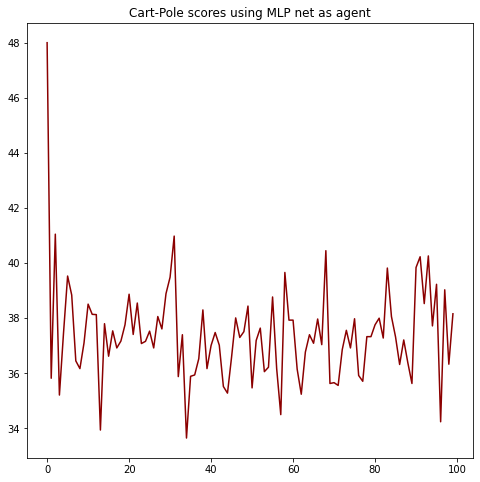

In [427]:
## See results, much better than the previous approach, however the definitive approach would be using CNN

import seaborn as sns
import matplotlib.pyplot as plt


f,ax=plt.subplots(figsize=(8,8))
ax=sns.lineplot(x=np.arange(len(scores_game)),y=scores_game,color="darkred")
ax.set_title("Cart-Pole scores using MLP net as agent");